In [1]:
#data format library
import h5py

#numpy
import numpy as np
import pandas as pd
import numpy.ma as ma
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)
plt.rcParams["font.family"] = "Times New Roman"
# %matplotlib notebook
import sys
sys.path.append('/Users/gautam.sridhar/Documents/Repos/Markov_Fish/utils/')
import matplotlib.colors as pltcolors
import os
import copy
import clustering_methods as cl
import operator_calculations as op_calc
import delay_embedding as embed
import stats
import time

np.random.seed(42)

<module 'operator_calculations' from '/Users/gautam.sridhar/Documents/Repos/Markov_Fish/utils/operator_calculations.py'>

In [2]:
condition_labels = ['Light (5x5cm)','Light (1x5cm)','Looming(5x5cm)','Dark_Transitions(5x5cm)',
                    'Phototaxis','Optomotor Response (1x5cm)','Optokinetic Response (5x5cm)','Dark (5x5cm)','3 min Light<->Dark(5x5cm)',
                    'Prey Capture Param. (2.5x2.5cm)','Prey Capture Param. RW. (2.5x2.5cm)',
                    'Prey Capture Rot.(2.5x2.5cm)','Prey capture Rot. RW. (2.5x2.5cm)','Light RW. (2.5x2.5cm)']

condition_recs = np.array([[453,463],[121,133],[49,109],[22,49],[163,193],[109,121],
                           [133,164],[443,453],[0,22],
                           [193,258],[304,387],[258,273],[273,304],
                           [387,443]])

In [3]:
conditions = np.zeros((np.max(condition_recs),2),dtype='object')
for k in range(len(condition_recs)):
    t0,tf = condition_recs[k]
    conditions[t0:tf,0] = np.arange(t0,tf)
    conditions[t0:tf,1] = [condition_labels[k] for t in range(t0,tf)]

In [4]:
## Load symbolic sequences

path_to_filtered_data = '/Users/gautam.sridhar/Documents/Repos/Markov_Fish/Datasets/JM_Data/'
f = h5py.File(path_to_filtered_data + 'kmeans_labels_K5_N1200_s8684.h5')
lengths_all = np.array(f['MetaData/lengths_data'], dtype=int)
labels_fish = ma.array(f['labels_fish'],dtype=int)
state_trajs = ma.array(f['state_trajs'])
f.close()


In [5]:
to_mask = 1300
maxL = np.max(lengths_all)

labels_fish[labels_fish == to_mask] = ma.masked

In [6]:
## Select Dataset
np.random.seed(42)
seeds = np.random.randint(0,10000,100)
delay_range = np.arange(1,20,1)
dt = 1
div= 463
n_modes=50
labels_all= ma.concatenate(labels_fish,axis=0)
print(labels_fish.shape)

(463, 11651)


In [7]:
P_ensemble = np.load('/Users/gautam.sridhar/Documents/Repos/Markov_Fish/Datasets/JM_Data/P_ensemble_ex8_N1200_s8684.npy')

In [8]:
from scipy.sparse import diags,identity,coo_matrix, csr_matrix
P_ensemble = csr_matrix(P_ensemble)

lcs_ensemble = msm_estimation.largest_connected_set(P_ensemble)
inv_measure = op_calc.stationary_distribution(P_ensemble)
final_labels = op_calc.get_connected_labels(labels_all,lcs_ensemble)

In [9]:
# Load eigenfunctions

# eigfunctions = np.load(path_to_filtered_data + 'eigfs_n1200.npy')
phi1 = eigfunctions[:,1]
phi2 = eigfunctions[:,2]
phi3 = eigfunctions[:,3]

# Uncomment to discover eigenfunctions and eigenvalues from ensemble transition matrix. 
# The estimation of eigenvalues is done through ARPACK, which is stochastic in nature. 
# This can result in the eigenvectors flipping sign. 
# If that happens, you can change the random seed in op_calc.sorted_spectrum()

# from scipy.sparse import diags,identity,coo_matrix, csr_matrix
# P_ensemble = csr_matrix(P_ensemble)

# import msmtools.estimation as msm_estimation
# delay = 3
# dt = 1
# print(delay)
# # lcs_ensemble,P_ensemble = op_calc.transition_matrix(labels_all,delay,return_connected=True)
# R = op_calc.get_reversible_transition_matrix(P_ensemble)
# eigvals,eigvecs = op_calc.sorted_spectrum(R,k=10,seed=123) 
# sorted_indices = np.argsort(eigvals.real)[::-1]
# eigvals = eigvals[sorted_indices][1:].real
# eigvals[np.abs(eigvals-1)<1e-12] = np.nan
# eigvals[eigvals<1e-12] = np.nan
# t_imp =  -(delay*dt)/np.log(np.abs(eigvals))
# eigfunctions = eigvecs.real/np.linalg.norm(eigvecs.real,axis=0)
# eigfunctions_traj = ma.array(eigfunctions)[final_labels,:]
# eigfunctions_traj[final_labels.mask] = ma.masked

3


In [11]:
# Transition matrix based calculations

from scipy.spatial import distance
from sklearn.cluster import KMeans

n_state = 7
kms = np.load('/Users/gautam.sridhar/Documents/Repos/Markov_Fish/Datasets/JM_Data/cg{}_labels.npy'.format(n_state))
# kms = coh_labels_phi1

cluster_traj_all = ma.copy(final_labels)
cluster_traj_all[~final_labels.mask] = ma.array(kms)[final_labels[~final_labels.mask]]
cluster_traj_all[final_labels.mask] = ma.masked

cluster_fish = cluster_traj_all.reshape(labels_fish.shape[0],labels_fish.shape[1])
cluster_fish_mask = cluster_fish.mask

print(cluster_fish.shape)


P_prj = ma.zeros((labels_fish.shape[0],n_state,n_state))
lcs_all = []
for cf in range(labels_fish.shape[0]):
    print(cf)
    lcs_spec,P_spec = op_calc.transition_matrix(cluster_fish[cf],delay=3, return_connected=True)
    lcs_all.append(lcs_spec.astype(int))
    for i,l in enumerate(lcs_spec):
        P_prj[cf, l,lcs_spec] = P_spec.todense()[i]

(463, 11651)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
2

In [15]:
def polygon(sides, radius=1, rotation=0, translation=None):
    one_segment = np.pi * 2 / sides

    points = [
        (np.sin(one_segment * i + rotation) * radius,
         np.cos(one_segment * i + rotation) * radius)
        for i in range(sides)]

    if translation:
        points = [[sum(pair) for pair in zip(point, translation)]
                  for point in points]

    return points

from matplotlib import patches
def draw_curved_arrow(idx0,point0,point1,hw,angle,color_array):
    style = "Simple, tail_width={}, head_width={}, head_length={}".format(hw,5*hw,7.5*hw)
    kw = dict(arrowstyle=style, color=color_array[idx0])
    a = patches.FancyArrowPatch(point0, point1,
                                 connectionstyle="arc3,rad={}".format(angle), **kw)
    plt.gca().add_patch(a)

def get_angle_array(idx,n_states):
    idx=0
    angle_array = np.zeros(n_states)
    for k in range(3):
        angle_array[idx-k-1]=.3*kx+k*.05
        if idx+k>n_states-1:
            angle_array[k-n_states+idx] = -.3*kx-k*.05
        else:
            angle_array[idx+k]=-.35*kx-k*.01
    return angle_array


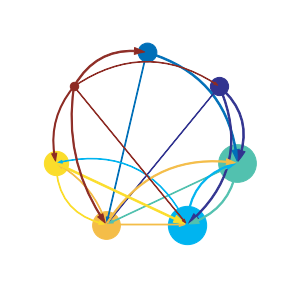

In [20]:
n_states=7
st_colors = ['#006FB8','#313390','#52C1AF','#00B4F0','#F4BD48','#FBDD2B','#8D2B24']
# st_colors = ['#1F50A3','#D04D49']

points = polygon(n_states)

Pc_d = copy.deepcopy(P_prj[3])
ih = op_calc.stationary_distribution(Pc_d)
# np.fill_diagonal(Pc_d, 0)
Pc_d[Pc_d<1e-1]=0
plt.figure(figsize=(5,5))
for k in range(n_states):
    plt.scatter(points[k][0],points[k][1],s=5000*ih[k],c=st_colors[k], zorder=0)
kx=-1
for idx in range(n_states):
    angle_array = get_angle_array(idx,n_states)*kx
    trans_indices = np.arange(0,n_states)
    trans_indices = trans_indices[trans_indices!=idx]
    for kj,j in enumerate(trans_indices):
        
        draw_curved_arrow(idx,points[idx],points[j],5*Pc_d[idx,j],angle_array[kj],st_colors)
    kx=kx*-1
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.axis('off')
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig4/tmat_eg_51.pdf')
plt.show()

In [21]:
# L1 distance
mean_js = ma.zeros((P_prj.shape[0],P_prj.shape[0]))
for cf1 in range(P_prj.shape[0]):
    print(cf1)      
    for cf2 in range(cf1+1):
        mean_js[cf1,cf2] = np.average(np.sum(np.abs(P_prj[cf1] - P_prj[cf2]), axis=1))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

(-0.5, 462.5, 462.5, -0.5)

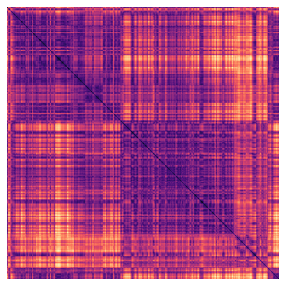

In [22]:
# tot_js_full = (tot_js+tot_js.T)/2
fig, ax = plt.subplots(1,1, figsize=(5,5))
mean_js_full = (mean_js+mean_js.T)
im = ax.imshow(mean_js_full,vmax = 1.5, cmap = 'magma')
# fig.colorbar(im)
ax.axis('off')
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig4/tmat_distances.pdf')
# fig.colorbar(im, ax=ax)

In [23]:
denoised_distmat_c = np.zeros(mean_js_full.shape)
denoised_distmat_c[:20,:20] = mean_js_full[443:463, 443:463]
denoised_distmat_c[:20,20:] = mean_js_full[443:463, :-20]
denoised_distmat_c[20:,:20] = mean_js_full[:-20, 443:463]

denoised_distmat_c[20:,20:] = mean_js_full[:443,:][:,:443]

(-0.5, 462.5, 462.5, -0.5)

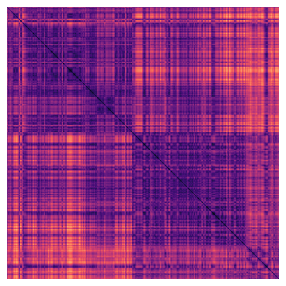

In [24]:
# tot_js_full = (tot_js+tot_js.T)/2
fig, ax = plt.subplots(1,1, figsize=(5,5))
im = ax.imshow(denoised_distmat_c,vmax = 1.8,cmap = 'magma')
# fig.colorbar(im)
ax.axis('off')
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig4/tmat_distances.pdf')
# fig.colorbar(im, ax=ax)

### Constant Shift Embedding for visualization

In [25]:
def CSE(D):
    """
    Perform constant shift embedding and return eigenvalues and eigenvectors on a distance matrix 
    """
    n = D.shape[0]
    
    Q = np.eye(n) - (1/n)*np.dot(np.ones((n,1)), np.ones((1,n)))
    # print(Q)
    Sc = -0.5*(np.dot(Q,np.dot(D,Q)))
    ei1, _ = np.linalg.eig(Sc)
    Dtilde = D - 2*(np.min(ei1))*(np.dot(np.ones((n,1)), np.ones((1,n))) - np.eye(n))

    Sctilde = -0.5*(np.dot(Q,np.dot(Dtilde,Q)))
    ei_fin, ev = np.linalg.eig(Sctilde)
    sorted_idx = np.argsort(ei_fin)[::-1]
    ei_fin = ei_fin[sorted_idx].real
    ev = ev[:,sorted_idx].real
    
    return ei_fin, ev

In [26]:
# Convert to similarity and extracting Euclidean embedding
ei_fin, ev = CSE(mean_js_full)

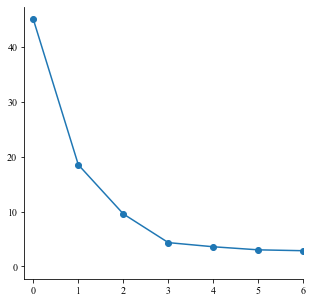

In [27]:
# Visualize eigenvalues of CSE to check dimensions
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(ei_fin ,marker='o')
ax.set_xlim(-0.2,6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [28]:
Xp = np.dot(ev[:,:4], np.sqrt(np.diag(ei_fin[:4])))

In [30]:
### Calculating the epsilon ball for each fish

# labels = labels_all
path_to_filtered_data = '/Users/gautam.sridhar/Documents/Repos/Markov_Fish/Datasets/JM_Data/'
f = h5py.File(path_to_filtered_data + 'simlabels_fish_K5_N1200_tau3_cg7.h5')
sims_fishnum = ma.asarray(f['MetaData/simfishes'], dtype=int)
lengths_sims = ma.asarray(f['MetaData/lengths_sims'], dtype=int)
sims_fish = ma.asarray(f['sim_labels'], dtype=int)
sims_fish_mask = ma.asarray(f['sim_labels_mask'])
f.close()
# to_mask = 1300

# sims_fish[sims_fish == to_mask] = ma.masked
sims_fish[sims_fish_mask.astype(bool)] = ma.masked

In [31]:
print(sims_fish.shape)

(100, 463, 11651)


In [32]:
#Calculate epsilon ball around single fish
n_states=7
delay=1
P_sims = np.zeros((len(sims_fish),n_states,n_states))
rec = 271
lcs_sims = []

for cf in range(len(sims_fish)):
    print(cf)
    lcs_spec,P_spec = op_calc.transition_matrix(sims_fish[cf,rec,:],delay=1, return_connected=True)
    lcs_sims.append(lcs_spec.astype(int))
    for i,l in enumerate(lcs_spec):
        P_sims[cf, l,lcs_spec] = P_spec.todense()[i]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [33]:
mean_js_sims = ma.zeros((P_sims.shape[0], P_prj.shape[0]))
for cf1 in range(P_sims.shape[0]):
    for cf2 in range(P_prj.shape[0]):
        mean_js_sims[cf1,cf2] = np.average(np.sum(np.abs(P_sims[cf1] - P_prj[cf2]), axis=1))

In [34]:
def CSE_project(Dnew, D):
    m = Dnew.shape[0]
    n = D.shape[0]
    
    Q = np.eye(n) - (1/n)*np.dot(np.ones((n,1)), np.ones((1,n)))
    t1 = np.dot(Dnew, Q)
    
    Sc = -0.5*(np.dot(Q,np.dot(D,Q)))
    ei1, _ = np.linalg.eig(Sc)
    Dtilde = D - 2*(np.min(ei1))*(np.dot(np.ones((n,1)), np.ones((1,n))) - np.eye(n))
    
    t2 = np.dot((1/n)*np.dot(np.ones((m,1)), np.ones((1,n))), np.dot(Dtilde,Q))
    
    Scnew = -0.5*(t1-t2)
    
    return Scnew

In [35]:
Scnew = CSE_project(mean_js_sims, mean_js_full)
Xpnew = np.dot(Scnew, np.dot(ev[:,:4], np.sqrt(np.diag(1/ei_fin[:4]))))
# plt.imshow(Scnew)

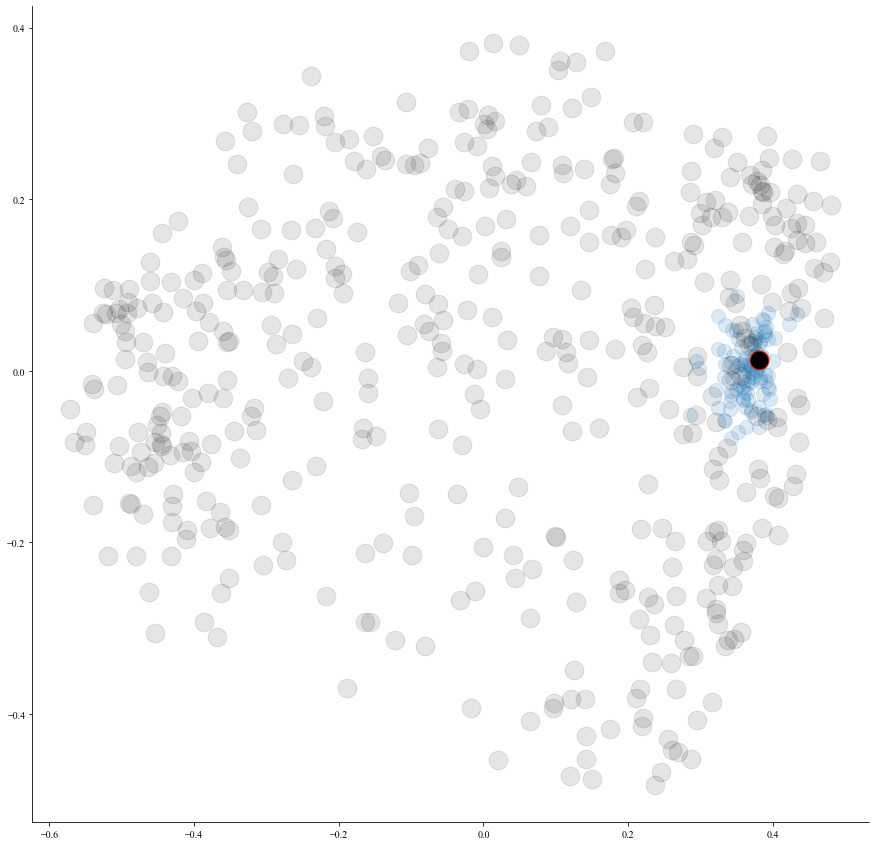

In [36]:
#Visualize epsilon ball around recording

from mpl_toolkits import mplot3d

# colors_range= plt.cm.rainbow(np.linspace(0,1,3))
# colors_ = colors_range[tmspace_cluster]

fig, ax = plt.subplots(1,1,figsize=(15,15))
# ax = plt.axes(projection='3d')
ax.scatter(-1*Xpnew[:,0],-1*Xpnew[:,1],s=200, alpha=0.15)
# ax.scatter(Xp[:,0],Xp[:,1], marker='d', ec='k',s=200, alpha=0.4)
cond=0
cond_recs = [271]
# print(cond_recs)
for i in range(conditions.shape[0]):
#     alpha=0.8
    if i in cond_recs:
        alpha = 1.
        ax.scatter(-1*Xp[i,0].real,-1*Xp[i,1].real,color='k',ec='r',s=350, alpha=alpha, zorder=30)#, marker=r'${}$'.format(j-start_rec))
    else:
        alpha = .1
        ax.scatter(-1*Xp[i,0].real,-1*Xp[i,1].real,color='k',ec='k',s=350, alpha=alpha, zorder=30)#, marker=r'${}$'.format(j-start_rec))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig4/tmat_space_rec271.pdf')
plt.show()

In [37]:
# Mean distance for all recordings

rec_mean = []
rec_cil = []
rec_ciu = []
n_state=7
delay=1
P_sim = np.zeros((n_state, n_state))
for rec in range(463):
    print(rec)
    mean_js_sim = []
    for s in range(100):
        sim = sims_fish[s,rec,:]
        sim[-1] = ma.masked
        P_sim[:,:] = 0.
        lcs_spec,P_spec = op_calc.transition_matrix(sim,delay=1, return_connected=True)
        for i,l in enumerate(lcs_spec):
            P_sim[l,lcs_spec] = P_spec.todense()[i]
        mean_js_sim.append(np.average(np.sum(np.abs(P_sim - P_prj[rec]), axis=1)))
    rec_mean.append(np.mean(mean_js_sim))
    rec_cil.append(np.nanpercentile(mean_js_sim, 2.5))
    rec_ciu.append(np.nanpercentile(mean_js_sim, 97.5))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

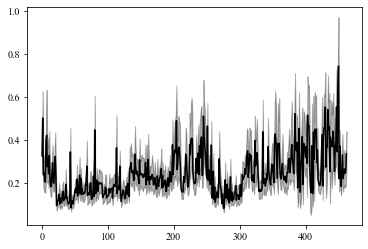

In [38]:
## Reported in Fig S5
plt.plot(np.asarray(rec_mean), c='k')
plt.fill_between(np.arange(463),np.asarray(rec_cil), np.asarray(rec_ciu),alpha=0.3, color='k')
# plt.ylim(0,9)
# plt.xlim(0,463)
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl11/epsilon_ball.pdf')

In [39]:
import skfuzzy as fuzz
def fuzzy_split(ev,indices,g_to_split,hard_assign,rb,dict_s):
    c, cr,_,_,_,_,_= fuzz.cmeans(ev[g_to_split][:,np.newaxis].T, 2,m=2,error=0.005,maxiter=1000)
    
    cr_preds = np.zeros((len(np.hstack(indices)),2))
    for i in range(len(ev)):
        if i == g_to_split:
            cr_preds[indices[i],:] = cr.T
        else:
            cr_pred,_,_,_,_,_ = fuzz.cmeans_predict(ev[i][:,np.newaxis].T, c,2,error=0.005,maxiter=1000)
            cr_preds[indices[i],:] = cr_pred.T
    
    new_rb = np.multiply(cr_preds, np.vstack([rb[:,g_to_split],rb[:,g_to_split]]).T)
    not_g_to_split = np.delete(np.arange(len(ev)),g_to_split)
    hard_assign[indices[g_to_split]] = np.argmax(cr,axis=0) + np.max(hard_assign) + 1
    
    dict_s.append([g_to_split,np.arange(len(np.unique(hard_assign))-2, len(np.unique(hard_assign)))])
    
    final_rb = np.zeros((rb.shape[0],len(np.unique(hard_assign))))
    final_rb[:,:len(np.unique(hard_assign))-2] = rb[:,not_g_to_split]
    final_rb[:,len(np.unique(hard_assign))-2:] = new_rb
    
    final_hard_assign = np.zeros(hard_assign.shape,dtype=int)

    for new_idx,label in enumerate(np.sort(np.unique(hard_assign))):
        final_hard_assign[hard_assign==label]=new_idx
        
    return final_hard_assign,final_rb,dict_s


def hfss(D,point_epsilon,n_groups=None):
    """
    A hierarchical fuzzy spectral clustering by performing fuzzy c-means on the Fiedler vectors from 
    multiple diffusion maps built from a distance matrix
    
    Parameters:
    D: The distance matrix. If the distance is Euclidean feed distance^2
    point_epsilon: The resolution parameter of every datapoint
    n_groups: The number of groups to split into. If None, then split will run until scale separation stops
    
    Returns:
    labels_tree: The cluster labels after a hard assign
    responsibilities: The posterior P(C|X)
    """
    
    eps = np.sqrt(np.outer(point_epsilon,point_epsilon))
    
    P = np.exp(-D/eps)
    P = P / P.sum(axis=1)[:, np.newaxis]
    
    diff_eig, diff_ev = np.linalg.eig(P)
    inv_measure = op_calc.stationary_distribution(P)
    
    diff_eigvecs = diff_ev/np.linalg.norm(diff_ev,axis=0)
    sorted_indices = np.argsort(diff_eig.real)[::-1]
    diff_eig = diff_eig[sorted_indices].real
    diff_eigvecs = diff_eigvecs[:,sorted_indices].real
    
    c, cr,_,_,_,_,_= fuzz.cmeans(diff_eigvecs[:,1][:,np.newaxis].T, 2,m=2,error=0.0005,maxiter=1000)
    
    hard_assign = np.argmax(cr,axis=0)
    
    respons = np.zeros((D.shape[0],2))
    respons = cr.T
    
    labels_tree=np.zeros((n_groups,len(hard_assign)),dtype=int)
    labels_tree[0,:] = hard_assign
    response_tree = []
    response_tree.append(respons)
    
    dict_split = []
    lambda_tree = []
    dist_rat_tree = []
    
    for g in range(1, n_groups):
        lambda_2=[]
        eigvecs_groups=[]
        indices_groups=[]
        P_groups=[]
        im_groups = []
        dist_rat = []
        rhos = []
        for g in np.unique(hard_assign):
            idx = np.where(hard_assign == g)[0]
            indices_groups.append(idx)
            eps_part = np.sqrt(np.outer(point_epsilon[idx],point_epsilon[idx]))
            D_part = D[idx,:][:,idx]
            ratio = D_part/eps_part
            P = np.exp(-ratio)
            P = P / P.sum(axis=1)[:, np.newaxis]
            if P.shape[0] == 1:
                lambda_2.append(diff_eig[1])
                eigvecs_groups.append(np.zeros((P.shape[0],)))
            else:
                diff_eig, diff_ev = np.linalg.eig(P)
                diff_eigvecs = diff_ev/np.linalg.norm(diff_ev,axis=0)
                
                sorted_indices = np.argsort(diff_eig.real)[::-1]
                diff_eig = diff_eig[sorted_indices].real
                diff_eigvecs = diff_eigvecs[:,sorted_indices].real
            
                im = op_calc.stationary_distribution(P)
                c, cr,_,_,_,_,_= fuzz.cmeans(diff_eigvecs[:,1].real[:,np.newaxis].T, 2,m=2,error=0.005,maxiter=1000)
                ha = np.argmax(cr,axis=0)
                rho = [(im[ha==k]*(P[ha==k,:][:,ha==k])).sum()/im[ha==k].sum() for k in range(2)]
                rhos.append(np.min(rho))
                im_groups.append(im)
                eigvecs_groups.append(diff_eigvecs[:,1].real)
                lambda_2.append(diff_eig[1])
                P_groups.append(P)
                dist_rat.append(ratio[np.triu_indices(ratio.shape[0],k=1)])
        
        measures = [(inv_measure[hard_assign==g]).sum() for g in np.unique(hard_assign)]
        lambda_tree.append(lambda_2)
        dist_rat_tree.append(dist_rat)
#         print(lambda_2)
#         print(-1/np.log(lambda_2))
        print(rhos)
        g_to_split = np.argmax(rhos)
        hard_assign,respons,dict_split = fuzzy_split(eigvecs_groups,indices_groups,g_to_split,hard_assign,respons,dict_split)
        
        labels_tree[g,:] = np.copy(hard_assign)
        response_tree.append(respons)
        g+=1
    
    return labels_tree, response_tree, lambda_tree,dist_rat_tree

In [40]:
labels_tree, response_tree, lambda_tree,dist_tree = hfss(mean_js_full,np.asarray(rec_mean),n_groups=10)

[0.6795770131799622, 0.612585116327522]
[0.612585116327522, 0.5473976918071966, 0.6281633283899745]
[0.612585116327522, 0.5473976918071966, 0.47317355170029035, 0.5376548267651422]
[0.5473976918071966, 0.47317355170029035, 0.5376548267651422, 0.6415977786056731, 0.6504333674251096]
[0.5473976918071966, 0.47317355170029035, 0.5376548267651422, 0.6415977786056731, 0.5123035482394982, 0.4730516390656983]
[0.5473976918071966, 0.47317355170029035, 0.5376548267651422, 0.5123035482394982, 0.4730516390656983, 0.4956675093814445, 0.4212064669336266]
[0.47317355170029035, 0.5376548267651422, 0.5123035482394982, 0.4730516390656983, 0.4956675093814445, 0.4212064669336266, 0.5809579971388226, 0.5378010401193817]
[0.47317355170029035, 0.5376548267651422, 0.5123035482394982, 0.4730516390656983, 0.4956675093814445, 0.4212064669336266, 0.5378010401193817, 0.6425308266753326, 0.4779921933279463]
[0.47317355170029035, 0.5376548267651422, 0.5123035482394982, 0.4730516390656983, 0.4956675093814445, 0.42120

In [41]:
##Stopping criterion

In [42]:
all_dists = []
for i in range(len(dist_tree)):
    all_dists.append(np.hstack(dist_tree[i]))

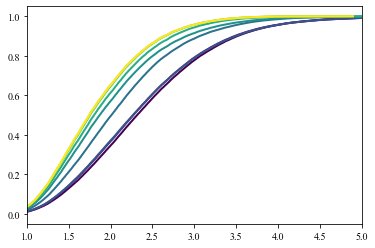

In [43]:
## Reported in Fig S5

bins = np.linspace(.2,6,10)
colors_ = plt.cm.viridis(np.linspace(0,1,len(all_dists)))
probs_k = []
for i in range(len(all_dists)):
    x,y = stats.cumulative_dist(all_dists[i],(0,10))
    h,_ = np.histogram(all_dists[i],bins=bins)
    probs_k.append(h)
    plt.plot(x,y,color = colors_[i], lw=2)
plt.xlim(1,5)
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig4/split_criterion_cdf.pdf')
plt.show()

In [50]:
# Load split to match color code from figures
spectral_split = np.load('/Users/gautam.sridhar/Documents/Repos/Markov_Fish/Datasets/JM_Data/spectral_split_g7.npy')
# Load posterior to match color code from figures
posterior = np.load('/Users/gautam.sridhar/Documents/Repos/Markov_Fish/Datasets/JM_Data/posterior.npy')

Looming(5x5cm)


<ipython-input-45-01afd38f6066>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['',''], fontsize=30)
<ipython-input-45-01afd38f6066>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['',''], fontsize=30)


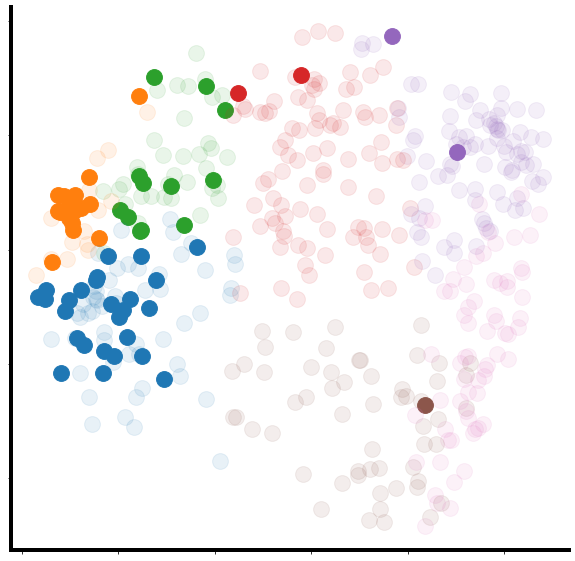

In [45]:
# Visualize Clustering

cond = 2
print(condition_labels[cond])
cond_recs = np.where(conditions[:,1] == condition_labels[cond])[0]

fig, ax = plt.subplots(1,1,figsize=(10,10))

for c in range(463):
    if c in cond_recs:
        alpha=1.0
    else:
        alpha=0.1
    ax.scatter(-1*Xp[c,0],-1*Xp[c,1],color='C{}'.format(spectral_split[c]),s=250, alpha=alpha)


# ax = plt.axes(projection='3d')
# im = ax.scatter(-1*Xp[:,0], -1*Xp[:,1], c=response_tree[2][:,0],cmap='PRGn',s=250, vmax =1., vmin=0)
# fig.colorbar(im)
# for g in range(7):
#     cond_recs = np.where(spectral_split == g)[0]
#     for i in cond_recs:
# #         alpha=post[i,g]
# #         print(post[i,g])
#         ax.scatter(-1*Xp[i,0],-1*Xp[i,1],color='C{}'.format(spectral_split[i]),s=300*post[i,g], alpha=1.)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# ax.view_init(45, 40)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(4)
ax.set_xticklabels(['',''], fontsize=30)
ax.set_yticklabels(['',''], fontsize=30)

# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig5/Tmat_space_pc_paramn.pdf')
plt.show()

In [30]:
# Use output of the clustering process
# spectral_split = labels_tree[5]
# posterior = response_tree[5]

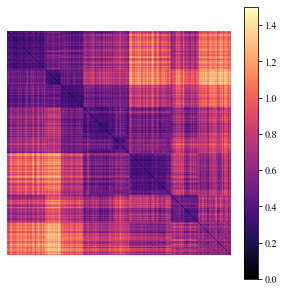

In [47]:
import matplotlib.colors as colors
fig, ax = plt.subplots(1,1,figsize=(5,5))
sort_clus_idx = np.argsort(spectral_split)
D2 = copy.deepcopy(mean_js_full)
D2[:] = D2[sort_clus_idx,:]
D2[:] = D2[:,sort_clus_idx]


im = ax.imshow(D2,cmap='magma', vmax = 1.5)
ax.axis('off')
fig.colorbar(im)
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig2/Tmat_WC_new.pdf')

In [44]:
# post_f = posterior/posterior.sum(axis=0)

<ipython-input-51-0033ce218bc4>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['',''], fontsize=30)
<ipython-input-51-0033ce218bc4>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['',''], fontsize=30)


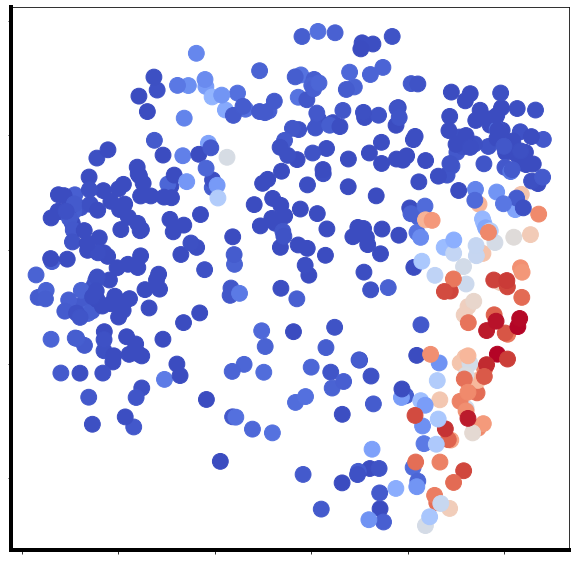

In [51]:
# Visualize posterior within cluster


# Visualize Clustering

# cond = 14
# print(condition_labels[cond])
# cond_recs = np.where(conditions[:,1] == condition_labels[cond])[0]

fig, ax = plt.subplots(1,1,figsize=(10,10))
# ax = plt.axes(projection='3d')
# sel = labels_tree[4] == 3
im = ax.scatter(-1*Xp[:,0], -1*Xp[:,1], c=posterior[:,6],cmap='coolwarm',s=250)
# im = ax.scatter(-1*Xp[~sel,0], -1*Xp[~sel,1], c='grey',s=250, alpha=0.4)
# fig.colorbar(im)

# ax.view_init(45, 40)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(4)
ax.set_xticklabels(['',''], fontsize=30)
ax.set_yticklabels(['',''], fontsize=30)

# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig4/Tmat_space_s6_post.pdf')
plt.show()

In [52]:
## Visualize behavioral grouos on phi1-phi2

In [53]:
split_locs = []
distorted_eigfs = np.zeros((eigfunctions.shape[0], eigfunctions.shape[1]-1))
for i in range(1,eigfunctions.shape[1]):
    phi = eigfunctions[:,i]
    _,_,_,split_idx,_ = op_calc.optimal_partition(phi,inv_measure,P_ensemble,return_rho=True)

    sort_range = np.sort(phi)
    neg_range = np.linspace(-1,0, len(sort_range[0:split_idx]))
    pos_range = np.linspace(0,1,len(sort_range[split_idx:]))
    distort_r = np.hstack([neg_range,pos_range])
    distort = np.zeros(phi.shape)

    pos = [np.where(phi == a)[0][0] for a in np.sort(phi)]

    for j in range(phi.shape[0]):
        distort[pos[j]] = distort_r[j]

    distorted_eigfs[:,i-1] = distort
    split_locs.append(split_idx)

In [54]:
distorted_trajs = ma.array(distorted_eigfs)[final_labels,:]
distorted_trajs[final_labels.mask] = ma.masked

distorted_fish = distorted_trajs.reshape(labels_fish.shape[0], labels_fish.shape[1], -1)

dtrajs_fish_phi1 = distorted_fish[:,:,0]
dtrajs_fish_phi2 = distorted_fish[:,:,1]

<ipython-input-57-260202a28eda>:17: UserWarning: linewidths is ignored by contourf
  im = ax.contourf(X,Y, img, cmap='Reds', linewidths=2, levels = 17)


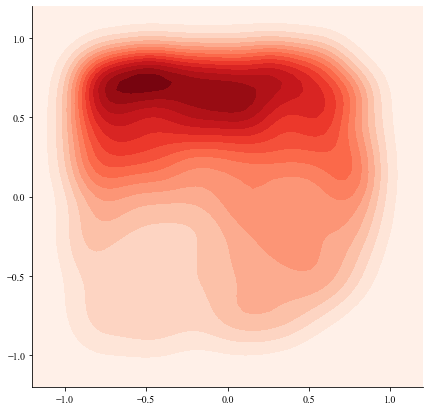

In [57]:
fig, ax  = plt.subplots(1,1,figsize=(7, 7))

xrange=[-1.2, +1.2]
yrange=[-1.2, +1.2]

clus=0
idx = np.where(spectral_split == clus)[0]
maxL = np.max(lengths_all[idx])
# print(maxL)

psi1 = ma.concatenate(distorted_fish[idx,:maxL,0], axis=0)
psi2 = ma.concatenate(distorted_fish[idx,:maxL,1], axis=0)

img= stats.density_plot(psi1.compressed(), psi2.compressed(), xrange, yrange, 50,50,smooth=True, border=3)

X,Y = np.meshgrid(np.linspace(-1.2,1.2,56), np.linspace(-1.2,1.2,56))
im = ax.contourf(X,Y, img, cmap='Reds', linewidths=2, levels = 17)

# im = ax.imshow(img, cmap='inferno', origin='lower')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig4/clus5_mes.pdf')


## Fig 6

In [58]:
## All condition ensembles visualized 

In [59]:
P_conds = np.zeros((len(condition_labels), n_state, n_state))
lcs_conds = []
delay=3

condition_labels = ['Light (5x5cm)','Light (1x5cm)','Looming(5x5cm)','Dark_Transitions(5x5cm)',
                    'Phototaxis','Optomotor Response (1x5cm)','Optokinetic Response (5x5cm)','Dark (5x5cm)','3 min Light<->Dark(5x5cm)',
                    'Prey Capture Param. (2.5x2.5cm)','Prey Capture Param. RW. (2.5x2.5cm)',
                    'Prey Capture Rot.(2.5x2.5cm)','Prey capture Rot. RW. (2.5x2.5cm)','Light RW. (2.5x2.5cm)']

for cf, cond in enumerate(condition_labels):
    print(cf)
    idx = np.where(conditions[:,1] == cond)[0]
    print(idx)
    lcs_cond, P_cond = op_calc.transition_matrix(ma.concatenate(cluster_fish[idx],axis=0),delay=delay, return_connected=True)
    lcs_conds.append(lcs_cond.astype(int))
    for i,l in enumerate(lcs_cond):
        P_conds[cf, l,lcs_spec] = P_cond.todense()[i]

0
[453 454 455 456 457 458 459 460 461 462]
1
[121 122 123 124 125 126 127 128 129 130 131 132]
2
[ 49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 104 105 106 107 108]
3
[22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45
 46 47 48]
4
[164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192]
5
[109 110 111 112 113 114 115 116 117 118 119 120]
6
[133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150
 151 152 153 154 155 156 157 158 159 160 161 162 163]
7
[443 444 445 446 447 448 449 450 451 452]
8
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
9
[193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210
 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228
 229 23

In [61]:
mean_js_conds = ma.zeros((P_conds.shape[0], P_prj.shape[0]))
for cf1 in range(P_conds.shape[0]):
    for cf2 in range(P_prj.shape[0]):
        mean_js_conds[cf1,cf2] = np.average(np.sum(np.abs(P_conds[cf1] - P_prj[cf2]), axis=1))

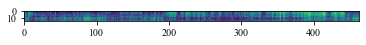

In [62]:
plt.imshow(mean_js_conds)

In [63]:
Scnew = CSE_project(mean_js_conds, mean_js_full)
# plt.imshow(Scnew)

In [64]:
Xpnew = np.dot(Scnew, np.dot(ev[:,:4], np.sqrt(np.diag(1/ei_fin[:4]))))

Light (5x5cm)


<ipython-input-65-9a35031d06d7>:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['',''], fontsize=30)
<ipython-input-65-9a35031d06d7>:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['',''], fontsize=30)


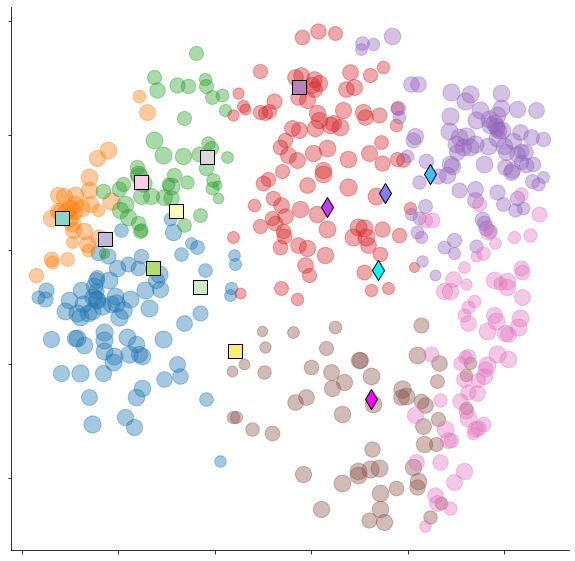

In [65]:
from mpl_toolkits import mplot3d

colors1_ = plt.cm.Set3(np.linspace(0.0,1.,11))
colors2_ = plt.cm.cool(np.linspace(0.0,1.,5))
colors_ = np.vstack([colors1_,colors2_])
colors_ = np.delete(colors_,[3,4],axis=0)
# colors_= plt.cm.rainbow(np.linspace(0,1,16))
# colors_ = colors_range[tmspace_cluster]


fig, ax = plt.subplots(1,1,figsize=(10,10))
cond = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
# print(condition_labels[cond[0]])
for i in cond:
    cond_recs = np.where(conditions[:,1] == condition_labels[i])[0]
    if i<9:
        ax.scatter(-1* Xpnew[i,0],-1*Xpnew[i,1], marker='s', ec='k',color = colors_[i],s=200, label=condition_labels[i], zorder=30, alpha=1.)
    else:
        ax.scatter(-1* Xpnew[i,0],-1*Xpnew[i,1], marker='d', ec='k',color = colors_[i],s=200, label=condition_labels[i], zorder=30, alpha=1.)
# ax.scatter(-1*Xp[:,0],-1*Xp[:,1],s=100,c=labels_tree[5],alpha=0.5, cmap='tab10')
# for c in cond:
#     cond_recs = np.where(conditions[:,1] == condition_labels[c])[0]

for g in range(7):
    cond_recs = np.where(spectral_split == g)[0]
    for i in cond_recs:
#         alpha=post[i,g]
#         print(post[i,g])
        ax.scatter(-1*Xp[i,0],-1*Xp[i,1],color='C{}'.format(spectral_split[i]),s=300*posterior[i,g], alpha=.4)
    
# for c in range(463):
#     ax.scatter(-1*Xp[c,0].real,-1*Xp[c,1].real,color='C{}'.format(labels_tree[5][c]),s=200, alpha=0.4, marker='o')

# ax.legend(loc="upper left",bbox_to_anchor=(1.1, 1.05), fontsize=25)
# ax.scatter(X_transformed[:,0],X_transformed[:,1],c = Y,cmap='tab10', alpha=.5,s =100)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# ax.view_init(45, 40)

# for axis in ['bottom','left']:
#     ax.spines[axis].set_linewidth(4)
ax.set_xticklabels(['',''], fontsize=30)
ax.set_yticklabels(['',''], fontsize=30)

# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig5/Tmat_space_allcond.pdf')
plt.show()

In [69]:
group=5
rb = response_tree[group]

means = []
cils = []
cius = []

for j,cond in enumerate([0,1,2,3,4,5,6,7,8,9,10,11,12,13]):
    cond_recs = np.where(conditions[:,1] == condition_labels[cond])[0]
    cond_resp = rb[cond_recs]
    m,cil,ciu = stats.bootstrap(cond_resp,n_times=1000)
    means.append(m)
    cils.append(cil)
    cius.append(ciu)
means = np.vstack(means).T
cils = np.vstack(cils).T
cius = np.vstack(cius).T

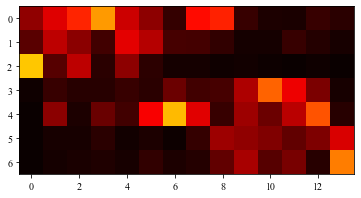

In [70]:
plt.imshow(means, cmap='hot',vmax = 1.0, vmin=0.0)
# plt.axis('off')
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig5/Conf_mat')

In [71]:
## Confusion matrix for each cluster for each condition
group=0
rb = response_tree[group]

In [72]:
means = []
cils = []
cius = []

for j,cond in enumerate([0,1,2,3,4,5,6,7,8,9,10,11,12,13]):
    cond_recs = np.where(conditions[:,1] == condition_labels[cond])[0]
    cond_resp = rb[cond_recs]
    m,cil,ciu = stats.bootstrap(cond_resp,n_times=1000)
    means.append(m)
    cils.append(cil)
    cius.append(ciu)
means = np.vstack(means).T
cils = np.vstack(cils).T
cius = np.vstack(cius).T

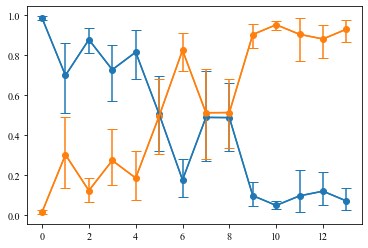

In [73]:
# means_rest = 1- means[3:5].sum(axis=0)
# cil_rest = 1-cius[3:5].sum(axis=0)
# ciu_rest = 1-cils[3:5].sum(axis=0)
for i in [0,1]:
    plt.plot(np.arange(len(means[i])),means[i], color = 'C{}'.format(i), marker='o')
    plt.errorbar(np.arange(len(means[i])),means[i],[means[i] - cils[i],cius[i]-means[i]],capsize=5,color='C{}'.format(i))
    
# plt.plot(np.arange(len(means_rest[0])),means_rest[0],color='grey', alpha=0.3, marker='o')
# plt.errorbar(np.arange(len(means_rest[0])),means_rest[0],[means_rest[0] - cils_rest[0],cius_rest[0]-means_rest[0]],
#              capsize=5,color='grey')
# plt.ylim(-0.1,1.1)
# plt.axhline(1/rb.shape[1], c='k',ls='--')
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig5/fifth_split_rest.pdf')

In [74]:
## Confusion matrix for each cluster for each condition
group=3
rb = response_tree[group]

In [75]:
print(np.unique(labels_tree[3]))

[0 1 2 3 4]


In [76]:
means = []
cils = []
cius = []

for j,cond in enumerate([0,1,2,3,4,5,6,7,8,9,10,11,12,13]):
    cond_recs = np.where(conditions[:,1] == condition_labels[cond])[0]
    cond_resp = rb[cond_recs]
    m,cil,ciu = stats.bootstrap(cond_resp,n_times=1000)
    means.append(m)
    cils.append(cil)
    cius.append(ciu)
means = np.vstack(means).T
cils = np.vstack(cils).T
cius = np.vstack(cius).T

In [77]:
means_rest = []
cils_rest = []
cius_rest = []

gs = [0,1,2]

for j,cond in enumerate([0,1,2,3,4,5,6,7,8,9,10,11,12,13]):
    cond_recs = np.where(conditions[:,1] == condition_labels[cond])[0]
    cond_resp = rb[cond_recs]
    m,cil,ciu = stats.bootstrap(np.sum(cond_resp[:,gs],axis=1).T,n_times=1000)
    means_rest.append(m)
    cils_rest.append(cil)
    cius_rest.append(ciu)
means_rest = np.vstack(means_rest).T
cils_rest = np.vstack(cils_rest).T
cius_rest = np.vstack(cius_rest).T

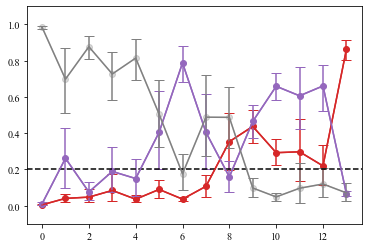

In [78]:
# means_rest = 1- means[3:5].sum(axis=0)
# cil_rest = 1-cius[3:5].sum(axis=0)
# ciu_rest = 1-cils[3:5].sum(axis=0)
for i in [3,4]:
    plt.plot(np.arange(len(means[i])),means[i], color = 'C{}'.format(i), marker='o')
    plt.errorbar(np.arange(len(means[i])),means[i],[means[i] - cils[i],cius[i]-means[i]],capsize=5,color='C{}'.format(i))
    
plt.plot(np.arange(len(means_rest[0])),means_rest[0],color='grey', alpha=0.3, marker='o')
plt.errorbar(np.arange(len(means_rest[0])),means_rest[0],[means_rest[0] - cils_rest[0],cius_rest[0]-means_rest[0]],
             capsize=5,color='grey')
plt.ylim(-0.1,1.1)
plt.axhline(1/rb.shape[1], c='k',ls='--')
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig5/fifth_split_rest.pdf')

In [79]:
## Confusion matrix for each cluster for each condition
group=4
rb = response_tree[group]

In [80]:
print(np.unique(labels_tree[4]))

[0 1 2 3 4 5]


In [81]:
means = []
cils = []
cius = []

for j,cond in enumerate([0,1,2,3,4,5,6,7,8,9,10,11,12,13]):
    cond_recs = np.where(conditions[:,1] == condition_labels[cond])[0]
    cond_resp = rb[cond_recs]
    m,cil,ciu = stats.bootstrap(cond_resp,n_times=1000)
    means.append(m)
    cils.append(cil)
    cius.append(ciu)
means = np.vstack(means).T
cils = np.vstack(cils).T
cius = np.vstack(cius).T

In [82]:
means_rest = []
cils_rest = []
cius_rest = []

gs = [0,1,2,3]

for j,cond in enumerate([0,1,2,3,4,5,6,7,8,9,10,11,12,13]):
    cond_recs = np.where(conditions[:,1] == condition_labels[cond])[0]
    cond_resp = rb[cond_recs]
    m,cil,ciu = stats.bootstrap(np.sum(cond_resp[:,gs],axis=1).T,n_times=1000)
    means_rest.append(m)
    cils_rest.append(cil)
    cius_rest.append(ciu)
means_rest = np.vstack(means_rest).T
cils_rest = np.vstack(cils_rest).T
cius_rest = np.vstack(cius_rest).T

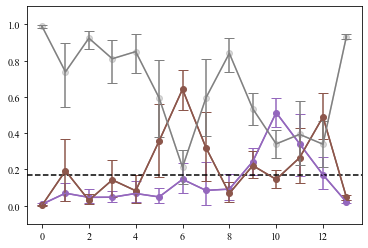

In [83]:
# means_rest = 1- means[3:5].sum(axis=0)
# cil_rest = 1-cius[3:5].sum(axis=0)
# ciu_rest = 1-cils[3:5].sum(axis=0)
for i in [4,5]:
    plt.plot(np.arange(len(means[i])),means[i], color = 'C{}'.format(i), marker='o')
    plt.errorbar(np.arange(len(means[i])),means[i],[means[i] - cils[i],cius[i]-means[i]],capsize=5,color='C{}'.format(i))
    
plt.plot(np.arange(len(means_rest[0])),means_rest[0],color='grey', alpha=0.3, marker='o')
plt.errorbar(np.arange(len(means_rest[0])),means_rest[0],[means_rest[0] - cils_rest[0],cius_rest[0]-means_rest[0]],
             capsize=5,color='grey')
plt.ylim(-0.1,1.1)
plt.axhline(1/rb.shape[1], c='k',ls='--')
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig5/fifth_split_rest.pdf')